# About

- Use [Langchain](https://python.langchain.com/en/latest/index.html) to build a chatbot that can answer questions about [Harry Potter books](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7)
- Experiment with various LLMs (Large Language Models)
- Use [ChromaDB vector store](https://python.langchain.com/docs/integrations/vectorstores/chroma) to store text embeddings with [Instructor-Finetuned Text Embeddings](https://arxiv.org/pdf/2212.09741.pdf) from [Hugging Face](https://huggingface.co/hkunlp/instructor-large)
- Use [Retrieval chain](https://python.langchain.com/docs/modules/data_connection/retrievers/) to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Chat UI with [Gradio](https://www.gradio.app/guides/quickstart)

No need to create any API key to use this notebook! Everything is open source.

Upvote the notebook if you learn from it or use it! :)

This will help me keep experimenting with new models as soon as they are released

### Models

- [WizardLM](https://huggingface.co/TheBloke/wizardLM-7B-HF)
- [Falcon](https://huggingface.co/h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2)
- [Llama 2-7b](https://huggingface.co/daryl149/llama-2-7b-chat-hf)
- [Llama 2-13b](https://huggingface.co/daryl149/llama-2-13b-chat-hf)
- [Bloom](https://huggingface.co/bigscience/bloom-7b1)

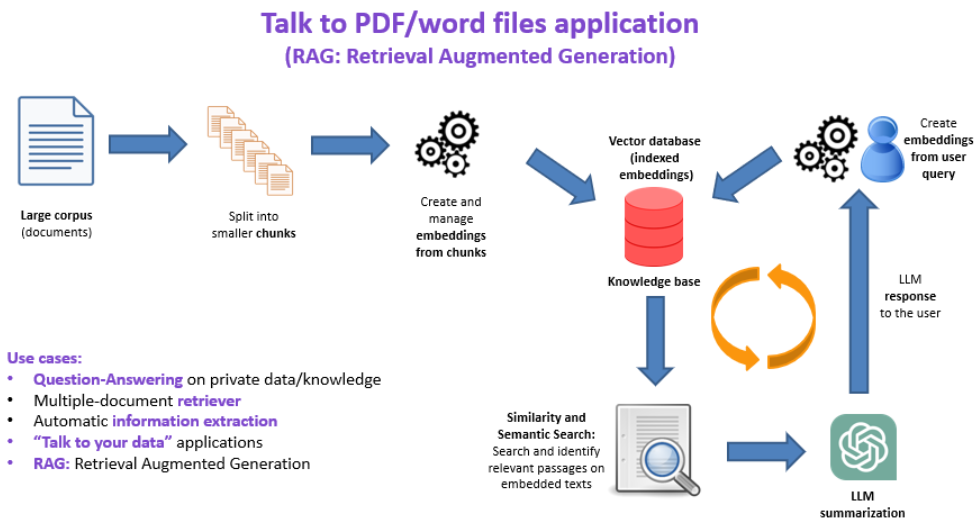

img source: HinePo

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-06b28577-c0f9-3da6-f6c3-058c2e6bf9bb)
GPU 1: Tesla T4 (UUID: GPU-6d5aabb7-bc35-4bca-e1bd-57583d4273ba)


# Installs

In [2]:
%%time

! pip install -qq -U langchain tiktoken pypdf chromadb faiss-gpu
! pip install -qq -U transformers InstructorEmbedding sentence_transformers
! pip install -qq -U accelerate bitsandbytes xformers einops

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.58.190319 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
google-cloud-pubsublite 1.8.1 requires overrides<7.0.0,>=6.0.1, but you have overrides 7.3.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
ydata-profiling 4.1.2 requires tqdm<4.65,>=4.48.2, but you have tqdm 4.65.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 2.0.1 which is incompatible.
CPU times: user 3.37 s, sys: 502 ms,

# Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, ConversationChain, LLMChain

# vector stores
from langchain.vectorstores import Chroma, FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA, ConversationalRetrievalChain

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

print(langchain.__version__)

0.0.249


In [4]:
glob.glob('/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/*')

['/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 1 - The Sorcerers Stone.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 5 - The Order of the Phoenix.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 3 - The Prisoner of Azkaban.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf',
 '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 2 - The Chamber of Secrets.pdf']

# CFG

- CFG class enables easy and organized experimentation 

In [5]:
class CFG:
    # LLMs
    model_name = 'llama2-13b' # wizardlm, bloom, falcon, llama2-7b, llama2-13b
    temperature = 0,
    top_p = 0.95,
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 800
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'hkunlp/instructor-base'    

    # similar passages
    k = 3
    
    # paths
    PDFs_path = '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/'
    Embeddings_path =  '/kaggle/input/private-hp-embeddings-instructor-base-800-0/harry-potter-vectordb-chroma'
    Persist_directory = './harry-potter-vectordb-chroma'  

# Define model

In [6]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
            )
        
        max_len = 1024

    elif model == 'llama2-7b':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )
        
        max_len = 2048

    elif model == 'llama2-13b':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )
        
        max_len = 8192

    elif model == 'bloom':
        model_repo = 'bigscience/bloom-7b1'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            )
        
        max_len = 1024

    elif model == 'falcon':
        model_repo = 'h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
            )
        
        max_len = 1024

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [7]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 50.7 s, sys: 1min 35s, total: 2min 25s
Wall time: 7min 45s


# 🤗 pipeline

- Hugging Face pipeline

In [8]:
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

llm = HuggingFacePipeline(pipeline = pipe)

In [9]:
llm

HuggingFacePipeline(cache=None, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, pipeline=<transformers.pipelines.text_generation.TextGenerationPipeline object at 0x79a450382d70>, model_id='gpt2', model_kwargs=None, pipeline_kwargs=None)

In [10]:
### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm(query)

".\n\nSure thing! Here are five examples of cool potions in the world of Dungeons & Dragons, along with a brief description of their effects:\n\n1. Potion of Healing: This potion restores hit points to the drinker, healing wounds and injuries sustained during combat or other physical activities. It's a staple of many adventurers' inventories, as it can be used to recover from dangerous battles or long journeys.\n2. Potion of Invisibility: As its name suggests, this potion grants the drinker temporary invisibility, allowing them to move undetected and strike from unexpected angles. It's often used by rogues and assassins to slip past guards or gain an advantage in stealthy situations.\n3. Potion of Speed: This potion increases the drinker's speed for a short period of time, allowing them to move faster and cover more ground than normal. It's useful for races like halflings and gnomes, who already have high movement speeds, but can also be helpful for other classes that rely on mobility.

# 🦜🔗 Langchain

- Multiple document retriever with LangChain

In [11]:
CFG.model_name

'llama2-13b'

## Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question

In [12]:
%%time

loader = DirectoryLoader(CFG.PDFs_path, 
                         glob="./*.pdf",
                         loader_cls=PyPDFLoader,
                         show_progress=True,
                         use_multithreading=True)

documents = loader.load()

100%|██████████| 7/7 [02:09<00:00, 18.50s/it]

CPU times: user 2min 9s, sys: 1.26 s, total: 2min 10s
Wall time: 2min 9s


In [13]:
len(documents)

4114

In [14]:
documents[8].page_content

"8Ron\nP.S. Percy's Head Boy. He got the letter last week.Harry glanced back at the photograph. Percy, who was in his seventh and\nfinal year at Hogwarts, was looking particularly smug. He had pinned hisHead Boy badge to the fez perched jauntily on top of his neat hair, hishorn-rimmed glasses flashing in the Egyptian sun.\nHarry now turned to his present and unwrapped it. Inside was what looked\nlike a miniature glass spinning top. There was another note from Ronbeneath it.\nHarry -- this is a Pocket Sneakoscope. If there's someone untrustworthy\naround, it's supposed to light up and spin. Bill says it's rubbish soldfor wizard tourists and isn't reliable, because it kept lighting up atdinner last night. But he didn't realize Fred and George had put beetlesin his soup.\nBye --RonHarry put the Pocket Sneakoscope on his bedside table, where it stood\nquite still, balanced on its point, reflecting the luminous hands of hisclock. He looked at it happily for a few seconds, then picked up the

## Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = CFG.split_chunk_size,
                                               chunk_overlap = CFG.split_overlap)

texts = text_splitter.split_documents(documents)
len(texts)

10519

## Embeddings

- Embedd and store the texts in a Vector database (ChromaDB or FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [One Embedder, Any Task: Instruction-Finetuned Text Embeddings - paper Dec/2022](https://arxiv.org/pdf/2212.09741.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)
- [Persist and load the vector database](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/chroma.html)

On this Harry Potter dataset, this embeddings creation and storage takes about ~35 minutes to complete with this embeddings function, configuration and compute power.

We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/hp-embeddings-instructor-base-800-0).

## Create vector database

In [16]:
# %%time

# ### download embeddings model
# instructor_embeddings = HuggingFaceInstructEmbeddings(model_name = CFG.embeddings_model_repo,
#                                                       model_kwargs = {"device": "cuda"})

# ### create embeddings and DB
# vectordb = Chroma.from_documents(documents = texts,
#                                  embedding = instructor_embeddings,
#                                  persist_directory = CFG.Persist_directory,
#                                  collection_name = 'hp_books')

# # vectordb.add_documents(documents=texts, embedding=instructor_embeddings)

# ### persist Chroma vector database
# vectordb.persist()

## Load vector database

- After persisting the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings
- After some experimentation I found out that there is a compatibility issue between Kaggle Public Datasets and Chroma. Loading the stored vector database as a Public Dataset does not work. It only works if the Dataset is Private. So you can either:
    - Create your own embeddings, save your vector store and then load it; or
    - Download the embeddings I've already created, upload them to your kaggle account (keeping it as a Private dataset), and load them in this notebook. This will work.
    - This compatibility issue does not happen in Google Colab.

In [17]:
%%time

### download embeddings model
instructor_embeddings = HuggingFaceInstructEmbeddings(model_name = CFG.embeddings_model_repo,
                                                      model_kwargs = {"device": "cuda"})

vectordb = Chroma(persist_directory = CFG.Embeddings_path,
                  embedding_function = instructor_embeddings,
                  collection_name = 'hp_books')

load INSTRUCTOR_Transformer
max_seq_length  512
CPU times: user 2.81 s, sys: 1.42 s, total: 4.23 s
Wall time: 10.1 s


In [18]:
### how many documents were loaded
print(vectordb._collection.count())

10519


# Prompt Template

- Custom prompt

In [19]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template=prompt_template, 
    input_variables=["context", "question"]
)

In [20]:
# llm_chain = LLMChain(prompt=PROMPT,
#                      llm=llm)
# llm_chain

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [21]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(llm = llm,
                                       chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
                                       retriever = retriever, 
                                       chain_type_kwargs = {"prompt": PROMPT},
                                       return_source_documents = True,
                                       verbose = False)

In [22]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

[Document(page_content='“Well,\tso\tthey\tsay,”\tsaid\tHagrid.\t“Crikey,\tI’d\tlike\ta\tdragon.”', metadata={'page': 49, 'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 1 - The Sorcerers Stone.pdf'}),
 Document(page_content='CHAPTER  TWENTY-EIGHT \n\x91 544 \x91 “Can you buy these as pets, Hagrid?” he asked excitedly as his \nniffler dived back into the soil, splattering his robes. \n“Yer mum wouldn’ be happy, Ro n,” said Hagrid, grinning. \n“They wreck houses, nifflers. I re ckon they’ve nearly got the lot, \nnow,” he added, pacing around the patch of earth while the nifflers \ncontinued to dive. “I on’y buried a hundred coins. Oh there y’are, \nHermione!” \nHermione was walking toward th em across the lawn. Her hands \nwere very heavily bandaged an d she looked miserable. Pansy \nParkinson was watc hing her beadily. \n“Well, let’s check how yeh’ve done!” said Hagrid. “Count yer \ncoins! An’ there’s no point tryin’ te r steal any, Goyle,” he added, 

In [23]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

[Document(page_content='CHAPTER  THIRTEEN \n\x91 198 \x91 nothing better than a pet drag on, as Harry, Ron, and Hermione \nknew only too well — he had owned one for a brief period during \ntheir first year, a vicious Norweg ian Ridgeback by the name of \nNorbert. Hagrid simply loved monstrous creatures, the more \nlethal, the better. \n“Well, at least the skrewts are sma ll,” said Ron as they made their \nway back up to the castle for lunch an hour later. \n“They are now, ” said Hermione in an exasperated voice, “but \nonce Hagrid’s found out what they eat, I expect they’ll be six feet \nlong.” \n“Well, that won’t matter if they turn out to cure seasickness or \nsomething, will it?” said Ro n, grinning slyly at her. \n“You know perfectly we ll I only said that to shut Malfoy up,”', metadata={'page': 213, 'source': '/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf'}),
 Document(page_content='CHAPTER  TWENTY-EIGHT \n\x91 544 \x91 “Can yo

## Post-process outputs

- Format llm response
- Cite sources (PDFs)

In [24]:
def wrap_text_preserve_newlines(text, width=200): # 110
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    sources_used = ' \n'.join([str(source.metadata['source']) for source in llm_response['source_documents']])
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [25]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Run QA Chain
- Talk to your data

In [26]:
CFG.model_name

'llama2-13b'

In [27]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [28]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

 During the Triwizard Tournament, Harry faces challenges such as competing against other students, dealing with the judging by Professor Moody, and facing the possibility of being eliminated from the
competition. Additionally, he must navigate the complexities of the tasks themselves, which include retrieving a golden egg from a dragon and navigating a maze.

Sources: 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 4 - The Goblet of Fire.pdf

Time elapsed: 17 s


In [29]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))

 No, based on the fact that Malfoy is visibly nervous when giving his wand to Voldemort and seems to expect to receive Voldemort's wand in return, indicating that he is not an ally of Voldemort.

Sources: 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf

Time elapsed: 11 s


In [30]:
query = "What are horcrux?"
print(llm_ans(query))

 Based on the information provided, Horcruxes are objects that contain a piece of Lord Voldemort's soul, making them incredibly important to him. It is believed that he would choose objects with a
certain level of grandeur or significance, and there are currently six known Horcruxes.

Sources: 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 6 - The Half-Blood Prince.pdf 
/kaggle/input/harry-potter-books-in-pdf-1-7/HP books/Harry Potter - Book 7 - The Deathly Hallows.pdf

Time elapsed: 14 s


In [31]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

 Sure! Here are five examples of cool potions from the passage:

1. The Draught of Peace - This potion calms anxiety and soothes agitation. However, if you use too much of the ingredients, the drinker will fall into a deep and sometimes irreversible sleep.
2. Scurvy-grass, Lovage, and Sneezewort Potion - These plants are effective in inflaming the brain and are often used in Confusing and Befuddlement Draughts to produce hot-headedness and recklessness.
3. Wizarding Level Potion - This potion allows the drinker to experience a sense of calm and control, even in difficult situations. It also helps to reduce stress and anxiety.
4. Gillyweed Potion - This potion allows the drinker to breathe underwater and stay submerged for longer periods of time. It is useful for wizards who enjoy water sports or need to explore underwater
environments.
5. Felix Felicis Potion - This potion creates a feeling of euphoria and happiness in the drinker, making them feel more confident and optimistic. It can

# Gradio Chat UI

- Create a chat UI with [Gradio](https://www.gradio.app/guides/quickstart)
- [ChatInterface docs](https://www.gradio.app/docs/chatinterface)
- The notebook should be running if you want to use the chat interface
- Print of the chat UI below

In [32]:
! pip install --upgrade gradio -qq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
import gradio as gr

def predict(message, history):
    # output = message # debug mode

    output = str(llm_ans(message))
    return output

demo = gr.ChatInterface(predict,
                        title = f' Open-Source LLM ({CFG.model_name}) for Harry Potter Question Answering')

demo.launch()

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://35443c13457cf3c460.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


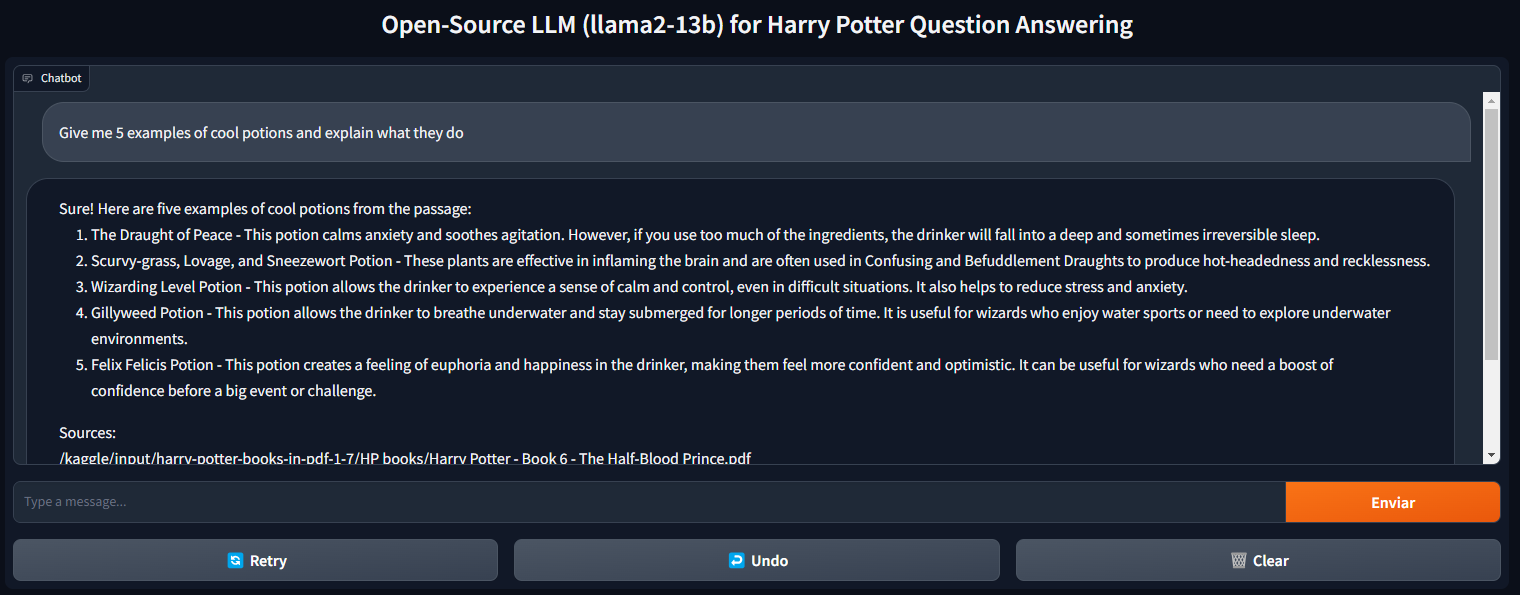

# Conclusions

- Feel free to fork and optimize the code. Lots of things can be improved. I'm planning to experiment with Memory soon.

- Things I found had the most impact on models output quality in my experiments:
    - Prompt engineering
    - Splitting: chunk size, overlap
    - Search: Similarity, MMR , k
    - Pipeline parameters (top_p, penalty)
    - Embeddings function
    - LLM parameters (max len)
    - Other models families
    - Bigger models


- LangChain, Hugging Face and Gradio are awesome libs!

- Upvote if you liked it or want me to keep updating this with new models and functionalities!

🦜🔗🤗

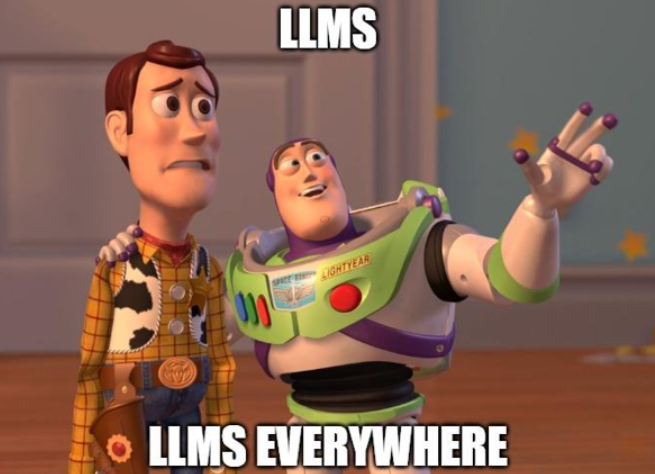